In [1]:
import pandas as pd
import numpy as np
import json
import pandas as pd
from cobra import Model, Reaction, Metabolite
from cobra.flux_analysis import flux_variability_analysis
import pickle
from tqdm import tqdm 
from ast import literal_eval
import cobra
import matplotlib.pyplot as plt
import numpy as np
from multiprocessing import Pool
from tqdm import tqdm
from functools import partial 
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import MaxNLocator, FormatStrFormatter
import multiprocessing as mp
import gurobipy
gurobipy.setParam('OutputFlag', 0)
import sys
sys.path.append('../retrosynthesis/')

from common import *


### input and output

In [2]:
###input
yeast870_path =  '../../Data/model/yeast-GEM.yml'

yeast8U_path = '../../Data/model/yeast8U_del2_re.yml'
essential_genes_path = '../../Data/model/essential_genes.json'
not_essential_genes_path = '../../Data/model/not_essential_genes.json'
# biolog_data_path = '../../biology/Biolog_Substrate.tsv'

###output
# ess_del_reaction_path = '../../Data/analysis/ess_del_reaction_df_re.csv'

gene_essential_confusion_matrix_figure_path = '../../Results/Figures/figS5-b.pdf'

In [8]:
with open(essential_genes_path) as f:
    essential_genes = json.load(f)
with open(not_essential_genes_path) as f:
    not_essential_genes = json.load(f)

In [3]:


def draw_confusion_matrix_figure(yeast8_TP, yeast8_TN, yeast8_FP, yeast8_FN, yeast8_Accuracy, 
                                 yeast8U_TP, yeast8U_TN, yeast8U_FP, yeast8U_FN, yeast8U_Accuracy, 
                                 figure_path, vmax):
    # Assume you have two sets of confusion matrix data
    confusion_matrix1 = np.array([[yeast8_TP, yeast8_FP], [yeast8_FN, yeast8_TN]])
    confusion_matrix2 = np.array([[yeast8U_TP, yeast8U_FP], [yeast8U_FN, yeast8U_TN]])

    # Create a figure, set the subplot layout to 1 row and 2 columns, with the right subplot being narrower
    fig = plt.figure(figsize=(1.5, 1.2), dpi=400)
    plt.rcParams['pdf.fonttype'] = 42
    
    gs = GridSpec(1, 3, width_ratios=[0.6, 0.6, 0.03])

    # First subplot
    ax1 = plt.subplot(gs[0])
    im1 = ax1.imshow(confusion_matrix1, cmap='Wistia', interpolation='nearest', vmin=1, vmax=vmax, aspect=2)
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.grid(False)
    ax1.text(0, 0, f"TP\n{confusion_matrix1[0, 0]}", ha='center', va='center', fontsize=6, color='black')
    ax1.text(1, 0, f"FP\n{confusion_matrix1[0, 1]}", ha='center', va='center', fontsize=6, color='black')
    ax1.text(0, 1, f"FN\n{confusion_matrix1[1, 0]}", ha='center', va='center', fontsize=6, color='black')
    ax1.text(1, 1, f"TN\n{confusion_matrix1[1, 1]}", ha='center', va='center', fontsize=6, color='black')
    ax1.set_xlabel(f"Yeast8\n(ACC = {yeast8_Accuracy:.2f})", fontsize=6, labelpad=-1)
    # Add border to the image
    for spine in ax1.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(0)

    # Second subplot
    ax2 = plt.subplot(gs[1])
    im2 = ax2.imshow(confusion_matrix2, cmap='Wistia', interpolation='nearest', vmin=1, vmax=vmax, aspect=2)
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.grid(False)
    ax2.text(0, 0, f"TP\n{confusion_matrix2[0, 0]}", ha='center', va='center', fontsize=6, color='black')
    ax2.text(1, 0, f"FP\n{confusion_matrix2[0, 1]}", ha='center', va='center', fontsize=6, color='black')
    ax2.text(0, 1, f"FN\n{confusion_matrix2[1, 0]}", ha='center', va='center', fontsize=6, color='black')
    ax2.text(1, 1, f"TN\n{confusion_matrix2[1, 1]}", ha='center', va='center', fontsize=6, color='black')
    ax2.set_xlabel(f"Yeast-MetaTwin\n(ACC = {yeast8U_Accuracy:.2f})", fontsize=6, labelpad=-1)
    # Add border to the image
    for spine in ax2.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(0)

    # Color bar
    cbar_ax = plt.subplot(gs[2])
    cbar = fig.colorbar(im2, cax=cbar_ax)
    cbar.ax.tick_params(labelsize=6)
    cbar.ax.yaxis.set_major_locator(MaxNLocator(nbins=6))
    # Add border to the image
    for spine in cbar_ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(0)

    # Adjust the spacing between subplots
    plt.subplots_adjust(wspace=0.02)
    # Save the image to a file
    plt.savefig(figure_path, dpi=400, bbox_inches='tight')
    plt.show()

In [4]:
yeast8_essential_predict_list,yeast8_notessential_predict_list = GEM_gene_essential(yeast870_path)

100%|██████████| 1163/1163 [01:59<00:00,  9.75it/s]


In [5]:
yeast8U_essential_predict_list_plus,yeast8U_notessential_predict_list_plus = GEM_gene_essential(yeast8U_path)

100%|██████████| 2045/2045 [05:34<00:00,  6.11it/s]


In [6]:
def get_accuracy_and_confusion_matrix_num(essential_predict_list,notessential_predict_list,essential_genes,not_essential_genes):
    TP = len(set(essential_predict_list) & set(essential_genes))
    TN = len(set(notessential_predict_list) & set(not_essential_genes))
    FP = len(set(essential_predict_list) - set(essential_genes))
    FN = len(set(notessential_predict_list) - set(not_essential_genes))
    Accuracy = round((TP + TN) / (TP + TN + FP + FN), 3)
    print(Accuracy)
    return TP,TN,FP,FN,Accuracy

In [10]:
for x in set(yeast8_notessential_predict_list):
    if x in set(not_essential_genes):
        print(x)

YGR256W
YLR174W
YGL067W
YLR350W
YLR450W
YBR252W
YPR128C
YKL019W
YKL140W
YGL038C
YOL157C
YLR130C
YMR319C
YEL039C
YDR105C
YML123C
YOR391C
YGR012W
YPL040C
YBR265W
YCR012W
YER087W
YGR183C
YCL064C
YDR400W
YJL219W
YOR384W
YBR004C
YMR011W
YDR147W
YHR216W
YOR192C
YGL191W
YEL066W
YGL255W
YGR154C
YOR221C
YLR158C
YOL151W
YHR067W
YLL043W
YLR153C
YBR291C
YDR508C
YLR308W
YBR038W
YHR162W
YPL273W
YPL059W
Q0250
YJR104C
YKR076W
YPL206C
YOR377W
YOR316C
YFL011W
YGR287C
YPL036W
YGR144W
YDL078C
YOR278W
YBR218C
YHL036W
YOR334W
YNR057C
YGR171C
YKR043C
YOL126C
YDR148C
YCR036W
YLR044C
YDR373W
YDL042C
YOR245C
YPL188W
YGR110W
YBL045C
YIR031C
YPR021C
YJR001W
YAL026C
YIR027C
YGL184C
YMR087W
YOR100C
YHR183W
YOR347C
YHL032C
YOR176W
YFR049W
YBR001C
YMR083W
YDL022W
YBR145W
YDR298C
YMR088C
YNL267W
YFL053W
YNL274C
YMR054W
YKR093W
YGR240C
YBR205W
YKR061W
YPR002W
YDR023W
YLR143W
YEL046C
YMR099C
YPR020W
YER065C
YDL174C
YOR143C
YDL219W
YJR069C
YPL258C
YNL130C
YOL020W
YDR377W
YOL152W
YHR068W
YGR208W
YLR354C
YOR306C
YOR081C
YJ

124 1921
124 1039
0.886
0.901
73 957 95 38 0.886
70 1773 54 148 0.901
0.886
0.921
73 957 95 38 0.886
70 1001 54 38 0.921


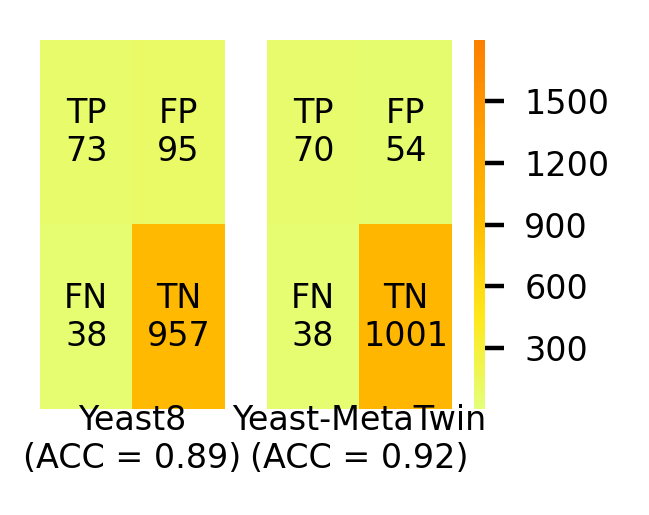

In [9]:
yeast8U_essential_predict_list_plus_old = [x for x in yeast8U_essential_predict_list_plus if x in yeast8_essential_predict_list or x in yeast8_notessential_predict_list]
yeast8U_notessential_predict_list_plus_old = [x for x in yeast8U_notessential_predict_list_plus if x in yeast8_essential_predict_list or x in yeast8_notessential_predict_list]
print(len(yeast8U_essential_predict_list_plus),len(yeast8U_notessential_predict_list_plus))
print(len(yeast8U_essential_predict_list_plus_old),len(yeast8U_notessential_predict_list_plus_old))


yeast8_TP,yeast8_TN,yeast8_FP,yeast8_FN,yeast8_Accuracy = get_accuracy_and_confusion_matrix_num(yeast8_essential_predict_list,yeast8_notessential_predict_list,essential_genes,not_essential_genes)
yeast8U_TP,yeast8U_TN,yeast8U_FP,yeast8U_FN,yeast8U_Accuracy= get_accuracy_and_confusion_matrix_num(yeast8U_essential_predict_list_plus,yeast8U_notessential_predict_list_plus,essential_genes,not_essential_genes)
print(yeast8_TP,yeast8_TN,yeast8_FP,yeast8_FN,yeast8_Accuracy)
print(yeast8U_TP,yeast8U_TN,yeast8U_FP,yeast8U_FN,yeast8U_Accuracy)

yeast8_TP,yeast8_TN,yeast8_FP,yeast8_FN,yeast8_Accuracy = get_accuracy_and_confusion_matrix_num(yeast8_essential_predict_list,yeast8_notessential_predict_list,essential_genes,not_essential_genes)
yeast8U_TP,yeast8U_TN,yeast8U_FP,yeast8U_FN,yeast8U_Accuracy= get_accuracy_and_confusion_matrix_num(yeast8U_essential_predict_list_plus_old,yeast8U_notessential_predict_list_plus_old,essential_genes,not_essential_genes)
print(yeast8_TP,yeast8_TN,yeast8_FP,yeast8_FN,yeast8_Accuracy)
print(yeast8U_TP,yeast8U_TN,yeast8U_FP,yeast8U_FN,yeast8U_Accuracy)

draw_confusion_matrix_figure(yeast8_TP,yeast8_TN,yeast8_FP,yeast8_FN,yeast8_Accuracy,yeast8U_TP,yeast8U_TN,yeast8U_FP,yeast8U_FN,yeast8U_Accuracy,gene_essential_confusion_matrix_figure_path,vmax=1799)